In [1]:
from __future__ import print_function, unicode_literals
import sys
import json

sys.path.append(".")
import argparse
from tqdm import tqdm
import torch
import subprocess
import numpy as np
import os

from src.models.my_wrap import Wrap_Resnet
from src.models.unsupervised.hybrid2_model import Hybrid2Model
from testing.fh_utils import (
    json_load,
    db_size,
    get_bbox_from_pose,
    read_img,
    convert_order,
    move_palm_to_wrist,
    modify_bbox,
    preprocess,
    create_affine_transform_from_bbox,
)

BBOX_SCALE = 0.33
CROP_SIZE = 224
# DS_PATH = "/hdd/Datasets/freihand_dataset/"
DS_PATH = "/home/dlc/cll/peclr/data/raw/freihand_dataset"

from pprint import pformat
from easydict import EasyDict as edict
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.loggers import CometLogger
from src.constants import (
    COMET_KWARGS,
    HYBRID2_CONFIG,
    SIMCLR_CONFIG ,
    BASE_DIR,
    TRAINING_CONFIG_PATH,
)
from src.data_loader.data_set_cbg import Data_Set
from src.data_loader.utils import get_data_cbg, get_train_val_split

from src.experiments.utils import (
    get_callbacks,
    get_general_args,
    get_model,
    prepare_name,
    save_experiment_key,
    update_model_params,
    update_train_params,
)
from src.utils import get_console_logger, read_json

In [2]:
experiment_type = "hybrid2"
# experiment_type = "simclr"
console_logger = get_console_logger(__name__)
args=[ 
                "--color_jitter",
                "--random_crop",
                "--rotate", 
                "--crop",
                "-resnet_size", "50",  
                "-sources", "freihand", 
                "--resize",   
                "-epochs", "500", 
                "-batch_size","128",  
                "-accumulate_grad_batches", "16", 
                "-save_top_k", "1",  
                "-save_period", "1",   
                "-num_workers", "8"
                # // "-d", "./kodim",
                # // "--epochs","300", 
                # // "-lr", "1e-4", 
                # // "--batch-size", "1",
                # // "--cuda", "--save",
                # // "--test-batch-size", "1"
            ]
# get_general_args("Hybrid model 2 training script.")
with open('args128.json','r+') as file:
    content=file.read()
    
content=json.loads(content)
args=argparse.Namespace(**content)
# args = get_general_args("Simclr model training script.")
train_param = edict(read_json(TRAINING_CONFIG_PATH))
train_param = update_train_params(args, train_param)
# model_param_path = SIMCLR_CONFIG
model_param_path = HYBRID2_CONFIG  # SIMCLR_CONFIG
model_param = edict(read_json(model_param_path))
console_logger.info(f"Train parameters {pformat(train_param)}")
seed_everything(train_param.seed)
data = get_data_cbg(
        Data_Set, train_param, sources=args.sources, experiment_type=experiment_type
    )
model_param = update_model_params(model_param, args, len(data), train_param)
model_param.augmentation = [
key for key, value in train_param.augmentation_flags.items() if value
]
console_logger.info(f"Model parameters {pformat(model_param)}")
model = get_model(
experiment_type="hybrid2",#"simclr"
heatmap_flag=args.heatmap,
denoiser_flag=args.denoiser,
)(config=model_param)
model=Hybrid2Model(config=model_param)

__main__ -INFO - Train parameters {'accumulate_grad_batches': 16,
 'augmentation_flags': {'color_drop': False,
                        'color_jitter': True,
                        'crop': True,
                        'cut_out': False,
                        'flip': False,
                        'gaussian_blur': False,
                        'gaussian_noise': False,
                        'random_crop': True,
                        'resize': True,
                        'rotate': True,
                        'sobel_filter': False},
 'augmentation_params': {'crop_box_jitter': [0.0, 15.0],
                         'crop_margin': 1.25,
                         'crop_margin_range': [0.9, 1.5],
                         'cut_out_fraction': [0.0, 0.16],
                         'hue_factor_range': [0.01, 1.0],
                         'max_angle': 45,
                         'min_angle': -45,
                         'noise_std': 25,
                         'resize_shape': [128, 128

In [40]:
model_path = '/home/zlc/cll/code/peclr_cbg/data/models/hybrid2-frei-bs256/epoch=286.ckpt'
model_path = '/home/zlc/cll/code/peclr/data/models/peclr-hybrid2-frei/6fef38348e444221a5b280e87cfb3a98/checkpoints/epoch=183.ckpt'
dev = torch.device("cuda")
checkpoint=torch.load(model_path)
model=Hybrid2Model(config=model_param)
model.load_state_dict(checkpoint['state_dict'])
model.eval()

KeyboardInterrupt: 

In [41]:
model_path = '/home/zlc/cll/code/peclr/data/models/peclr-hybrid2-frei/6fef38348e444221a5b280e87cfb3a98/checkpoints/epoch=183.ckpt'
dev = torch.device("cuda")
checkpoint=torch.load(model_path)
model2=Hybrid2Model(config=model_param)
model2.load_state_dict(checkpoint['state_dict'])
model2.eval()

Hybrid2Model(
  (encoder): ResNetModel(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)


In [4]:
import cv2
img_name = "/home/zlc/cll/code/peclr/data/raw/freihand_dataset/training/rgb/00000000.jpg"
img = cv2.cvtColor(cv2.imread(img_name),cv2.COLOR_BGR2RGB)

In [5]:
# import matplotlib.pyplot as plt
# plt.imshow(img)
# trafo = lambda x: np.transpose(x[:, :, ::-1], [2, 0, 1]).astype(np.float32) / 255.0 - 0.5
# img_t = trafo(img)
# batch = torch.Tensor(np.stack([img_t], 0)).cuda()

In [52]:
from src.data_loader.data_set_cbg import Data_Set
from torchvision import transforms
from torch.utils.data import DataLoader
train_param = edict(
    read_json("./src/experiments/config/training_config.json")
)
train_param.augmentation_flags.resize = True
train_param.augmentation_flags.random_crop = True
train_data2 = Data_Set(
    config=train_param,
    transform=transforms.ToTensor(),
    split="train",
    experiment_type="supervised",
    source="freihand",
)
train_data2.is_training=False
# print(da)
data_loader2 = DataLoader(train_data2, batch_size=128, num_workers=4)
# data = get_data_cbg(
#         Data_Set, train_param, sources=args.sources, experiment_type="supervised"
#     )


In [59]:
from src.data_loader.data_set_cbg import Data_Set_cbg
from torchvision import transforms
from torch.utils.data import DataLoader
train_param = edict(
    read_json("./src/experiments/config/training_config.json")
)
train_param.augmentation_flags.resize = True
train_param.augmentation_flags.random_crop = True
train_data2 = Data_Set_cbg(
    config=train_param,
    transform=transforms.ToTensor(),
    split="train",
    experiment_type="supervised",
    source="freihand",
)
train_data2.is_training=False
# print(da)
data_loader2 = DataLoader(train_data2, batch_size=128, num_workers=4)
# data = get_data_cbg(

ImportError: cannot import name 'Data_Set_cbg' from 'src.data_loader.data_set_cbg' (/home/zlc/cll/code/peclr_cbg/src/data_loader/data_set_cbg.py)

32559


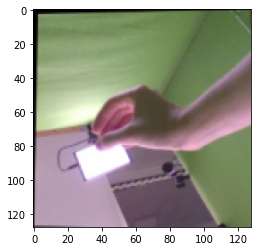

In [53]:
import matplotlib.pyplot as plt
print(len(train_data2))
c=train_data2[90]
c['image'].shape
d=np.array(c['image'])
e=np.zeros((128,128,3))
for i in range(3):
    e[:,:,i]=d[i,:,:]
plt.imshow(e)

In [29]:
emb=[]
print(len(data_loader))
j=0
for i in enumerate(data_loader):
    # print(len(i))
    # print(i[1].keys())
    # break
    print(len(i[1]['image']))
    model.eval()
    tmp=model.get_encodings(i[1]['image'])
    emb+=tmp
    if j==2:
        break
    j=j+1

255
128
128
128


In [42]:
for m2 in enumerate(data_loader):
    break
    # plt.imshow()
    d=i[1]['image'][0]
    for k in range(3):
        e[:,:,k]=d[k,:,:]
    plt.imshow(e)
    plt.show()
    d=i[1]['image'][1]
    for k in range(3):
        e[:,:,k]=d[k,:,:]
    plt.imshow(e)
    break

In [36]:
emb2=[]
model.eval()
tmp=model.get_encodings(i[1]['image'])
emb2+=tmp

ValueError: operands could not be broadcast together with shapes (0,) (128,2048) 

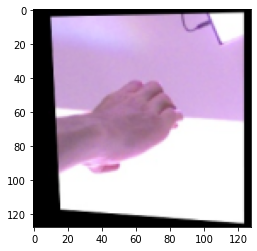

0.8262476


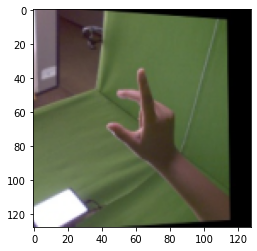

In [39]:

ind=2
d=i[1]['image'][ind]
for k in range(3):
    e[:,:,k]=d[k,:,:]
plt.imshow(e)
plt.show()
d=i[1]['image'][ind+1]
for k in range(3):
    e[:,:,k]=d[k,:,:]
plt.imshow(e)


cossim = lambda x, y: np.sum(x*y)/np.linalg.norm(x, 2)/np.linalg.norm(y, 2)
s=cossim(tmp[ind].detach().numpy(),tmp[ind+1].detach().numpy())
print(s)

In [44]:
emb2=model2.get_encodings(m2[1]['image'])

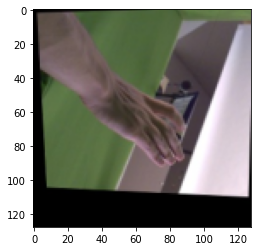

0.7818642
0.7870501


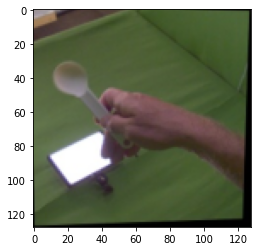

In [49]:

ind=100
d=i[1]['image'][ind]
for k in range(3):
    e[:,:,k]=d[k,:,:]
plt.imshow(e)
plt.show()
d=i[1]['image'][ind+1]
for k in range(3):
    e[:,:,k]=d[k,:,:]
plt.imshow(e)


cossim = lambda x, y: np.sum(x*y)/np.linalg.norm(x, 2)/np.linalg.norm(y, 2)
s=cossim(tmp[ind].detach().numpy(),tmp[ind+1].detach().numpy())
print(s)
s2=cossim(emb2[ind].detach().numpy(),emb2[ind+1].detach().numpy())
print(s2)

In [28]:
import json
with open('emb.json','w') as f:
    f_j=json.dump(np.array(emb),f)
    # f.write(f_j)
f.close()

TypeError: Object of type ndarray is not JSON serializable